In [1]:
import json
import requests
import tensorflow as tf
from PIL import Image
import numpy as np
import zipfile
import matplotlib.pyplot as plt

In [2]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
test_data_num = 100
BASE_PATH = "run/"
with open(BASE_PATH+"data.json", "r") as f:
    data = json.load(f)

In [3]:
images = []
rotations = []
positions = []

for item in data["Data"]:
    image = Image.open(BASE_PATH + item["image"])
    #image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    image = np.array(image) / 127.5 - 1
    rot = [[0 for x in range(3)] for y in range(1)] 
    rot[0][0] = item["orientation"][0]
    rot[0][1] = item["orientation"][1]
    rot[0][2] = item["orientation"][2]
    position = item["position"]
    images.append(image[None,:,:,:3])
    rotations.append(rot)
    positions.append(position)


In [4]:
images = np.array(images)
rotations = np.array(rotations)
positions = np.array(positions)

In [5]:
train_images = images[test_data_num:]
train_rotations = rotations[test_data_num:]
train_positions = positions[test_data_num:]

test_images = images[:test_data_num]
test_rotations = rotations[:test_data_num]
test_positions = positions[:test_data_num]

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_rotations))
validation_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_rotations))

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print(len(list(train_dataset)))
print(len(list(test_dataset)))
print(len(list(validation_dataset)))

900
20
80


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
                                               include_top=False,
                                               weights='imagenet')

In [9]:
image_batch, label_batch = next(iter(train_dataset))

feature_batch = base_model(image_batch)
print(feature_batch.shape)

(1, 7, 7, 1280)


In [10]:
base_model.trainable = False

In [11]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(1, 1280)


In [13]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(1, 3)


In [14]:
inputs = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01

In [16]:
len(model.trainable_variables)

2

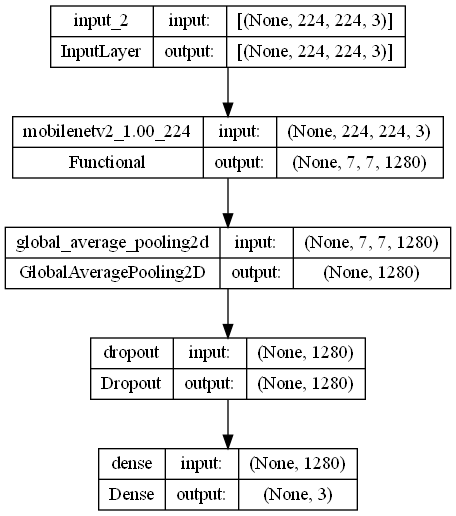

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [18]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [19]:
loss0, accuracy0 = model.evaluate(test_dataset)

20/20 [==============================] - 1s 15ms/step - loss: 1.9662 - accuracy: 0.3500


In [20]:
model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

Epoch 1/10
900/900 [==============================] - 17s 16ms/step - loss: 0.6354 - accuracy: 0.4533 - val_loss: 0.3922 - val_accuracy: 0.4625
Epoch 2/10
900/900 [==============================] - 14s 16ms/step - loss: 0.4228 - accuracy: 0.5333 - val_loss: 0.3433 - val_accuracy: 0.6000
Epoch 3/10
900/900 [==============================] - 15s 16ms/step - loss: 0.3411 - accuracy: 0.5767 - val_loss: 0.2708 - val_accuracy: 0.6000
Epoch 4/10
900/900 [==============================] - 15s 16ms/step - loss: 0.3096 - accuracy: 0.6089 - val_loss: 0.2208 - val_accuracy: 0.5500
Epoch 5/10
900/900 [==============================] - 14s 16ms/step - loss: 0.2737 - accuracy: 0.6389 - val_loss: 0.2553 - val_accuracy: 0.6125
Epoch 6/10
900/900 [==============================] - 15s 16ms/step - loss: 0.2538 - accuracy: 0.6422 - val_loss: 0.2307 - val_accuracy: 0.6625
Epoch 7/10
900/900 [==============================] - 14s 16ms/step - loss: 0.2927 - accuracy: 0.6311 - val_loss: 0.3268 - val_accuracy:

In [21]:
model.save_weights('./checkpoints/my_checkpoint')

In [22]:
inputs = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Restore the weights
model.load_weights('./checkpoints/my_checkpoint')

In [23]:
model.evaluate(test_dataset)

20/20 [==============================] - 1s 16ms/step - loss: 0.2097 - accuracy: 0.7500


[0.20974981784820557, 0.75]

In [27]:
def plot(guess, t_pos, t_rot, t_image):
    center_x = IMAGE_WIDTH/2
    center_y = IMAGE_HEIGHT/2

    mag = np.sqrt(t_pos.dot(t_pos))
    multi = 1

    pos_x = t_pos[0] * center_x * multi / mag + center_x
    pos_y = t_pos[1] * center_y * multi / mag + center_y

    screen_rot_x = t_rot[0] * center_x * multi / mag + pos_x
    screen_rot_y = t_rot[1] * center_y * multi / mag + pos_y

    screen_guess_rot_x = guess[0] * center_x * multi / mag + pos_x
    screen_guess_rot_y = guess[1] * center_y * multi / mag + pos_y


    x1 = [screen_rot_x, pos_x]; y1 = [screen_rot_y, pos_y] 
    x2 = [screen_guess_rot_x, pos_x]; y2 = [screen_guess_rot_y, pos_y] 


    fig, ax = plt.subplots()
    ax.axline((x1[0], y1[0]), (x1[1], y1[1]), color='green', label='by points')
    ax.axline((x2[0], y2[0]), (x2[1], y2[1]), color='red', label='by points')

    #plt.plot(x, y, color="purple", linewidth=3) 
    plt.axis('off')
    plt.ylim([0, t_image.shape[0]])
    plt.imshow(np.flipud(t_image))

    print("Rot pred:   ", pred[0])
    print("Rotation:   ", t_rot)
    print("Position: ", t_pos)
    plt.show() 

In [28]:
test_index = 0

1/1 [==============================] - 0s 22ms/step
Rot pred:    [-0.06940232 -0.49421376 -0.9872105 ]
Rotation:    [ 0.34255356 -0.49611151 -0.79782856]
Position:  [-0.42544341  1.21270299 11.82391834]


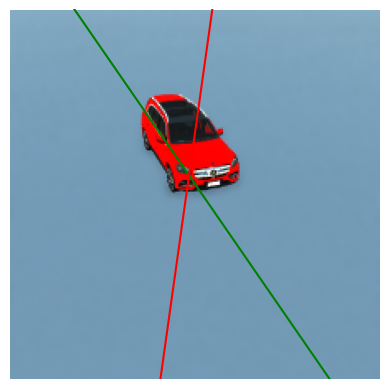

In [33]:
test = []
test.append(test_images[test_index])
test = np.array(test)
test_image = tf.data.Dataset.from_tensor_slices((test, test_rotations[test_index]))

pred = model.predict(test_image)

modified = []
for image in test:
    image = np.array(image) + 1
    image = np.array(image) / 2
    modified.append(image)
modified = np.array(modified)


plot(pred[0], test_positions[test_index], test_rotations[test_index][0], modified[0][0])
test_index = test_index +1